Problem Set 3 - Finetune Flowers 102 - Holly Darter

Importing the neccessary libraries and modules

In [1]:
import numpy as np
import urllib.request
from PIL import Image
from imageio import *
from skimage.transform import resize
from mpl_toolkits.axes_grid1.axes_rgb import make_rgb_axes, RGBAxes
from torchvision import models
from torchvision.models import *
from torchvision.datasets import MNIST, KMNIST, FashionMNIST
from skimage.util import montage
import skimage.io as skio
from scipy import signal
from torchvision import transforms
import requests
from torchsummary import summary
import torch
from torchvision import datasets, transforms
import os
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

Plotting a tensor using Matplotlib - moving the tensor to CPU and converting to numpy

In [2]:
def plot(x,title=None):
    x_np = x.cpu().numpy()
    if x_np.shape[0] == 3 or x_np.shape[0] == 1: # If tensor is in (C, H, W) format, transpose to (H, W, C)
        x_np = x_np.transpose(1, 2, 0)
    if x_np.shape[2] == 1: # If grayscale, squeeze the color channel
        x_np = x_np.squeeze(2)
        x_np = x_np.clip(0, 1) # Clip values to the valid range [0, 1]
        fig, ax = plt.subplots() # Create a Matplotlib figure and axis
        if len(x_np.shape) == 2:   # Display the image in grayscale or color
         im = ax.imshow(x_np, cmap='gray')
        else:
          im = ax.imshow(x_np)
        plt.title(title) # Set plot title and turn off axis ticks
        ax.axis('off')
        fig.set_size_inches(10, 10) # Set the figure size and display the plot
        plt.show()


 Display a tensor or numpy array as a grayscale image using Matplotlib

In [3]:
def plot2(x):
    if type(x) == torch.Tensor : # Check if the input is a torch.Tensor
        x = x.cpu().detach().numpy()
    fig, ax = plt.subplots() # Create a Matplotlib figure and axis
    im = ax.imshow(x, cmap='gray')  # Display the image in grayscale
    ax.axis('off')  # Turn off axis ticks
    fig.set_size_inches(10, 10)  # Set the figure size and display the plot
    plt.show()

Train a PyTorch model using the specified number of epochs.

In [4]:
def train_model(model, num_epochs=10):

    model = model.to(device) # Move the model to the specified device (e.g., GPU)
    criterion = torch.nn.CrossEntropyLoss() # Define the loss function (CrossEntropyLoss) and optimizer (SGD)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler with step decay
    # Training loop
    for epoch in range(num_epochs):
        print('Epoch: ',epoch+1,'/',num_epochs)
        # Train phase
        model.train()
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #Print(labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        # Adjust learning rate based on scheduler
        scheduler.step()
         # Validation phase
        model.eval()
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)
        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

Downloading and extracting the dataset


In [5]:
!wget https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip 'flower_data.zip' &>/dev/null

--2023-12-05 18:12:09--  https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘Oxford-102_Flower_dataset_labels.txt’

Oxford-102_Flower_d 100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-12-05 18:12:09 (19.8 MB/s) - ‘Oxford-102_Flower_dataset_labels.txt’ saved [1608/1608]

--2023-12-05 18:12:10--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.63.72, 52.217.93.86, 52.216.218.240, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.63.72|:443... connected.

Directory containing the flower dataset

In [6]:
data_dir = '/content/flower_data/'

Mean and standard deviation for normalizing images

In [7]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Data Augmentation
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

Transform to preprocess images for model input

In [8]:
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Data Augmentation
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

Data transformations for training and validation datasets

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Data Augmentation
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

Batch size for data loaders

In [10]:
batch_size = 16

Create image datasets and data loaders for training and validation

In [11]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes


Device (GPU or CPU) for training

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Load flower dataset labels

In [13]:
dataset_labels = pd.read_csv('Oxford-102_Flower_dataset_labels.txt', header=None)[0].str.replace("'", "").str.strip()

Transformation to convert tensor to PIL image

In [14]:
to_pil = ToPILImage()

Define the AlexNet model and move it to the specified device

In [15]:
net = models.alexnet(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 99.3MB/s]


Plotting some of the images alongside their label

In [16]:
batchsz = 1
dataloader2 = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batchsz, shuffle=True)
import random
for n in range(10):
  im, la = next(iter(dataloader2))
  plot(im[0],dataset_labels[int(class_names[la[0].item()])-1])

Showing alexnet output of images and their predicted label

Predicted class: sea urchin


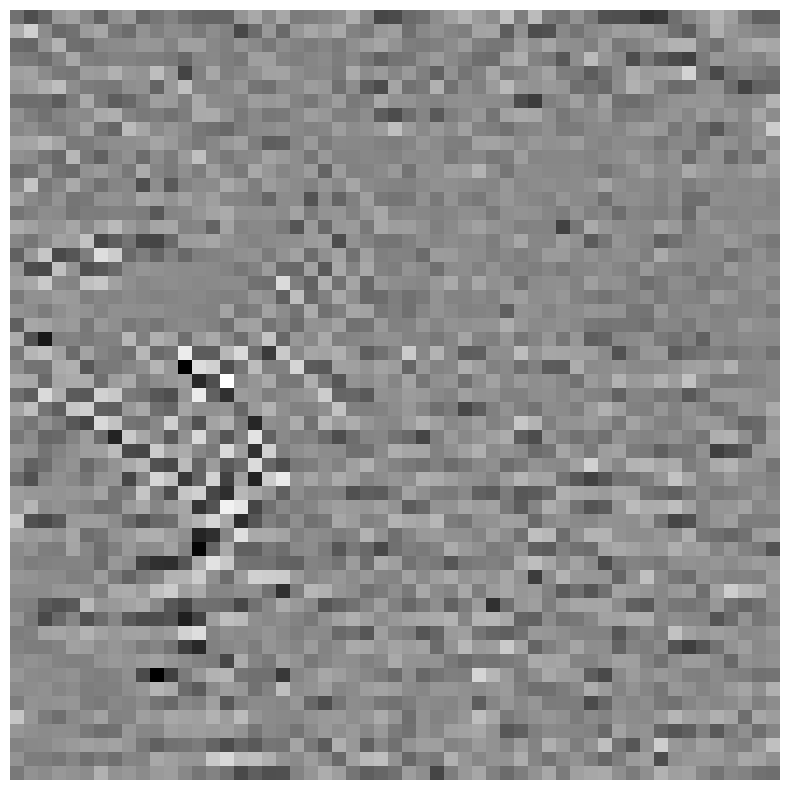

Predicted class: pinwheel


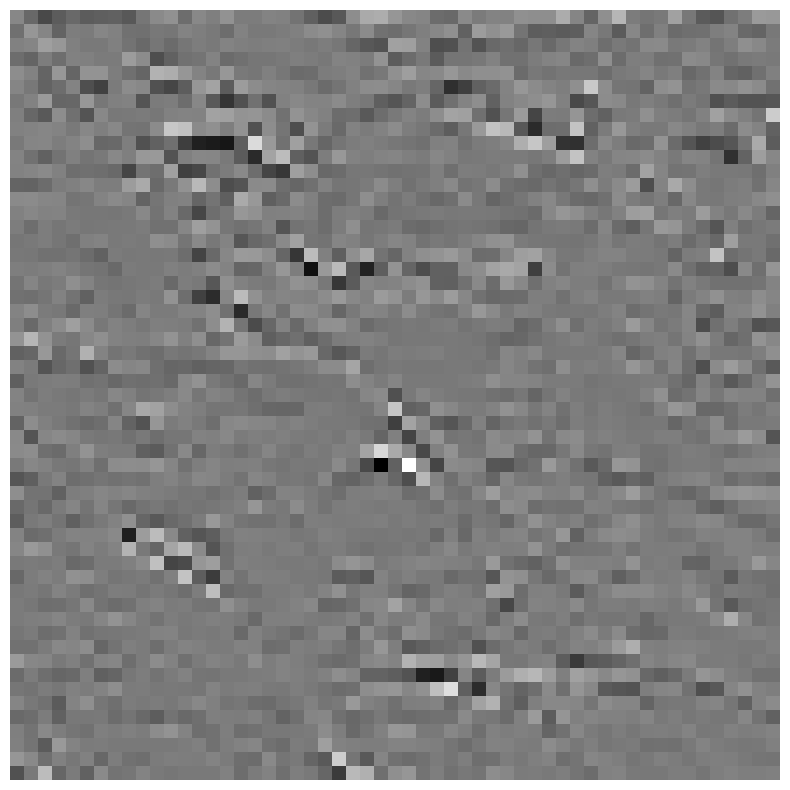

Predicted class: poncho


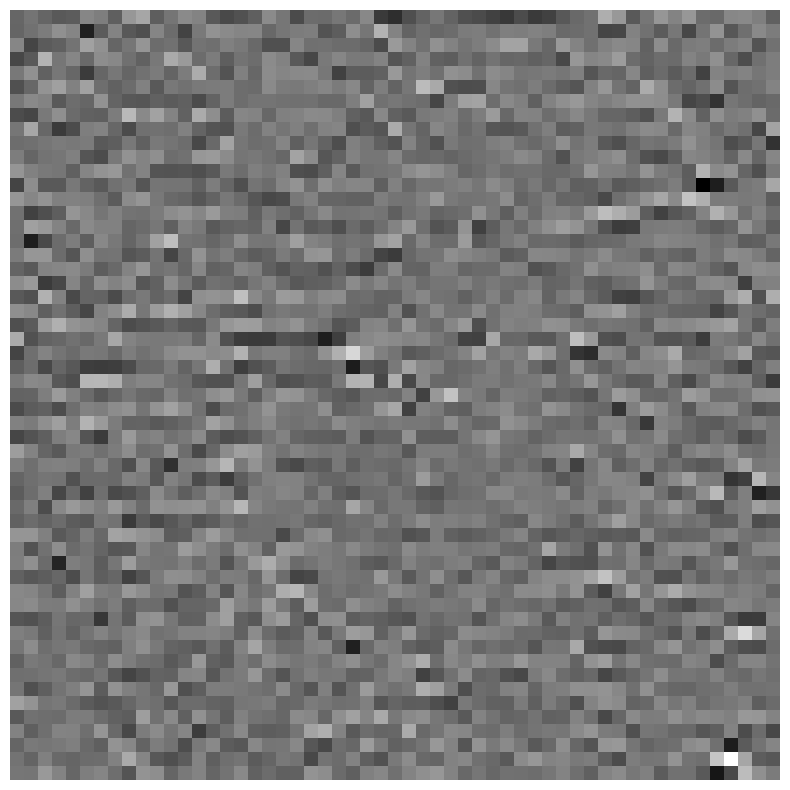

Predicted class: poncho


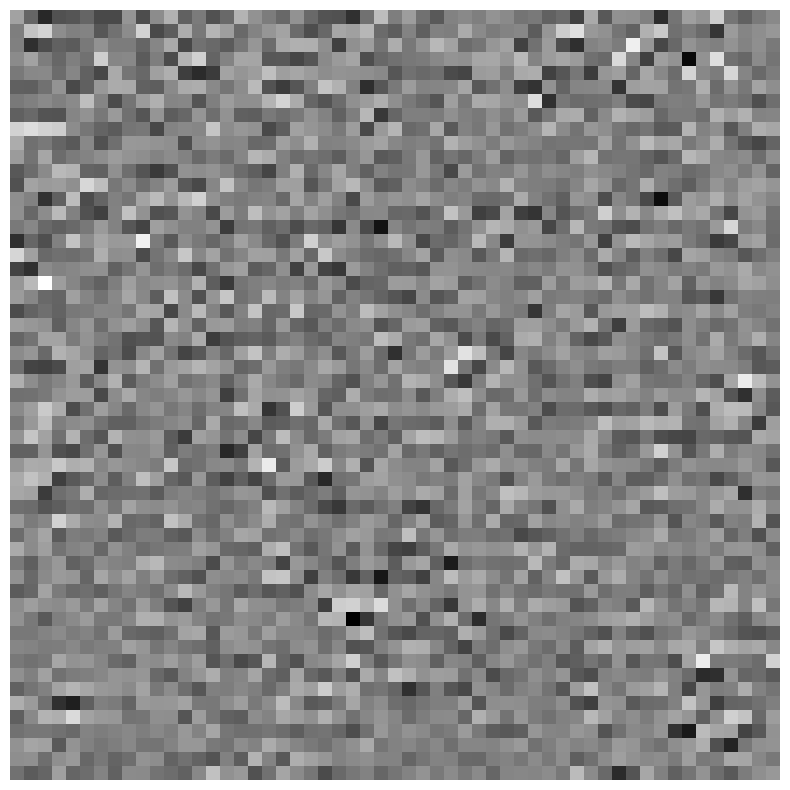

Predicted class: mailbag, postbag


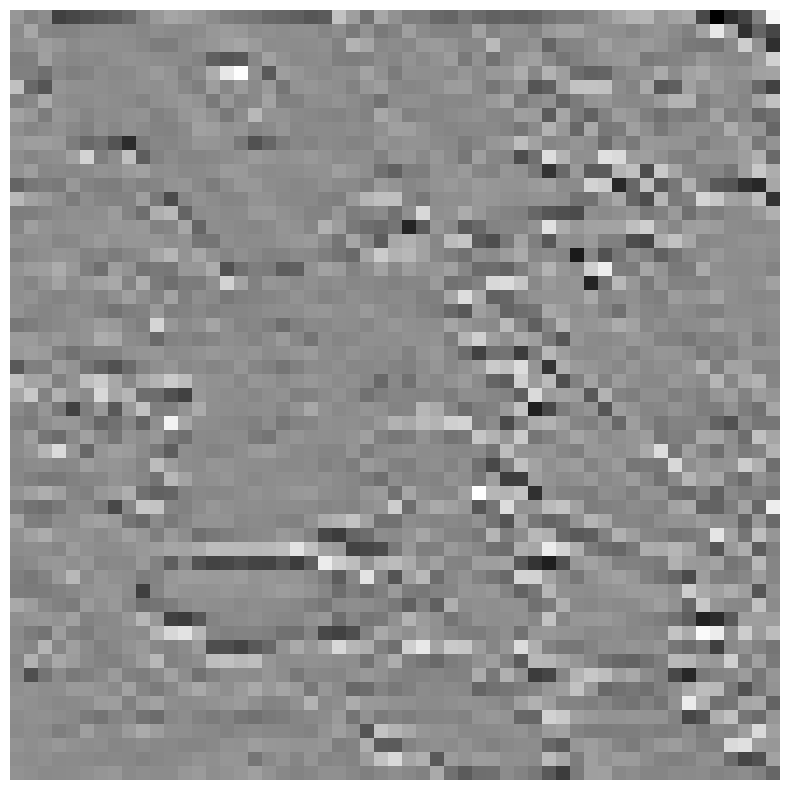

Predicted class: sarong


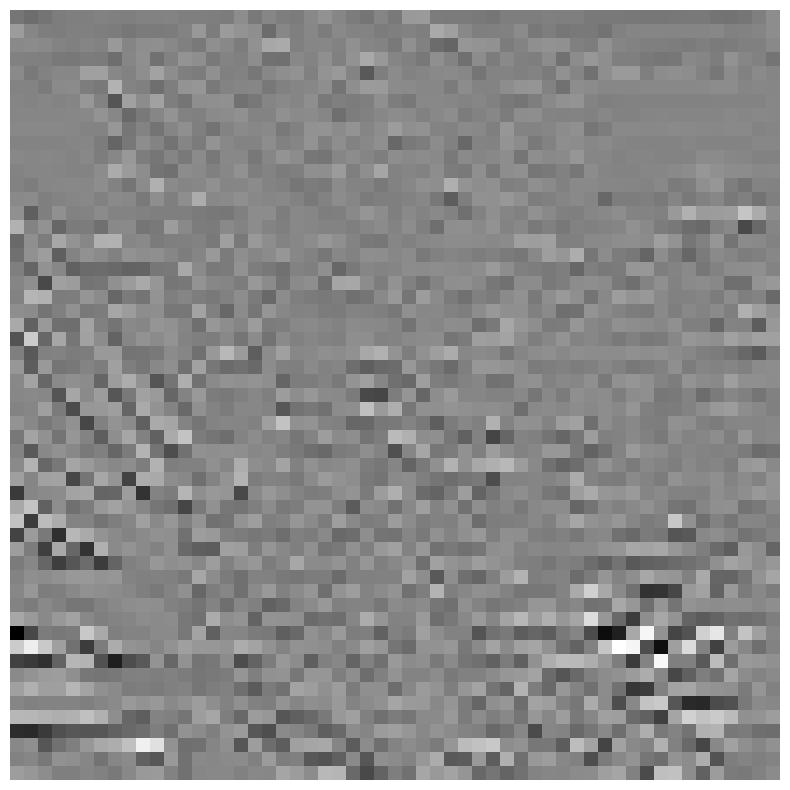

Predicted class: prayer rug, prayer mat


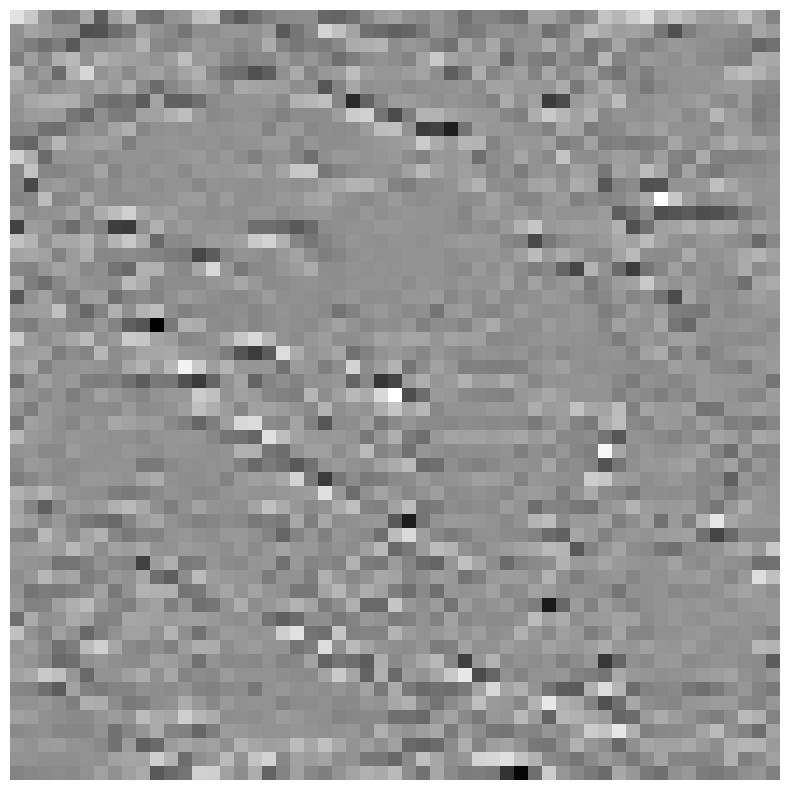

Predicted class: pillow


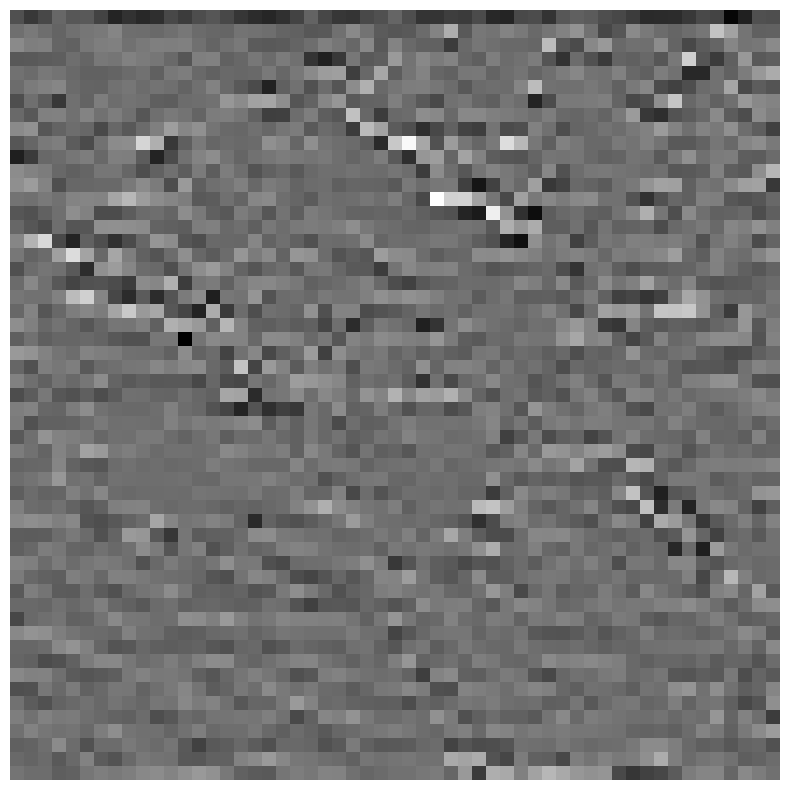

Predicted class: Christmas stocking


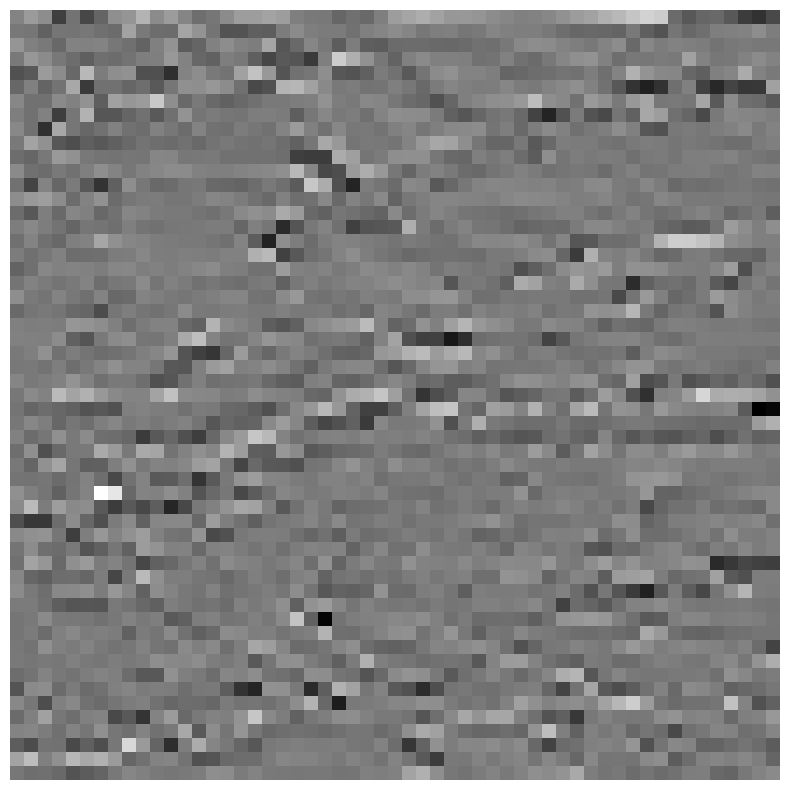

Predicted class: sarong


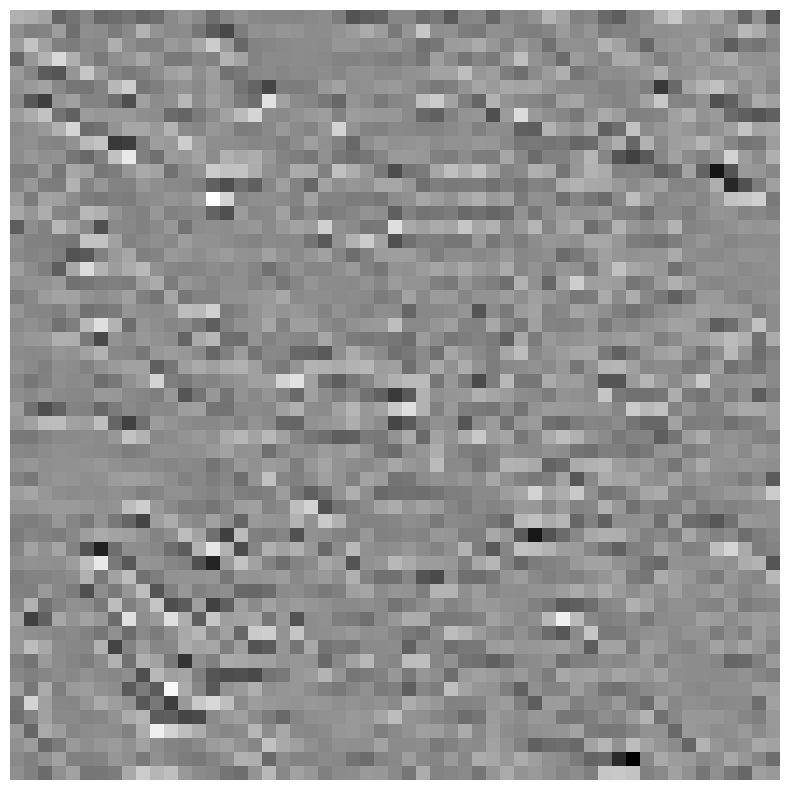

Predicted class: poncho


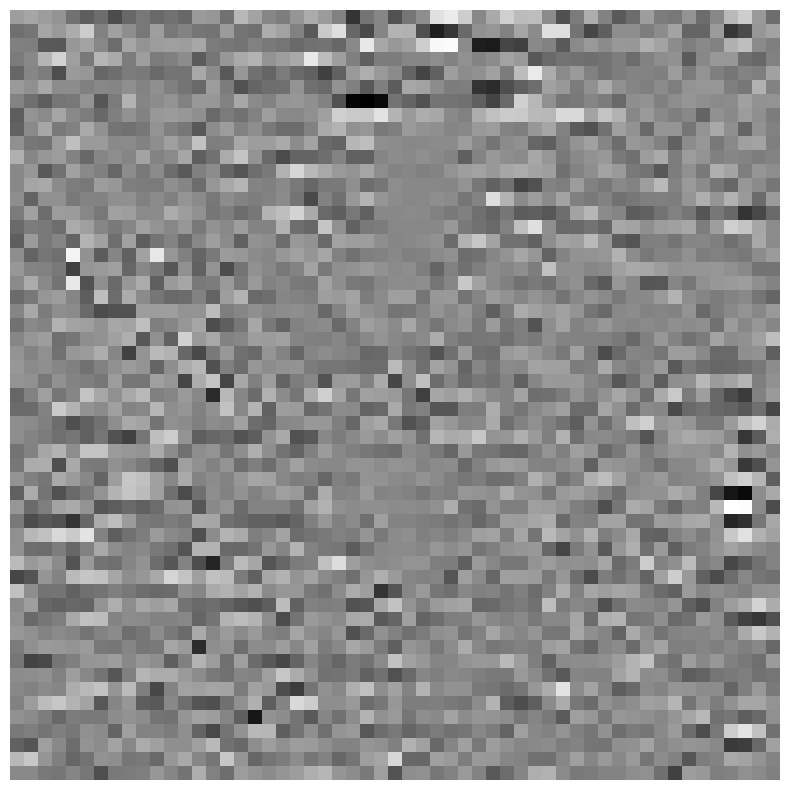

Predicted class: maypole


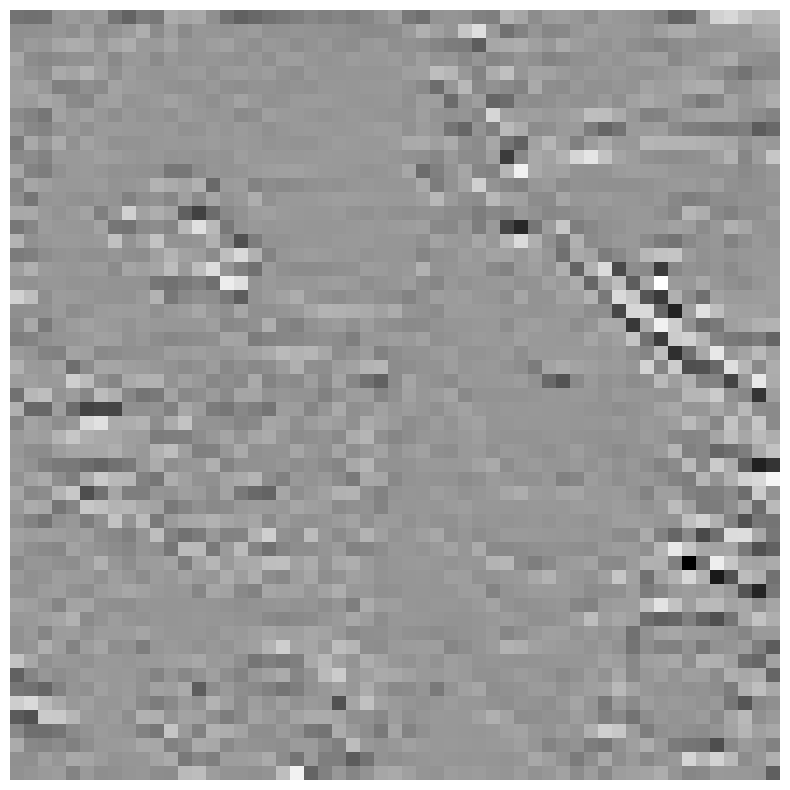

Predicted class: bib


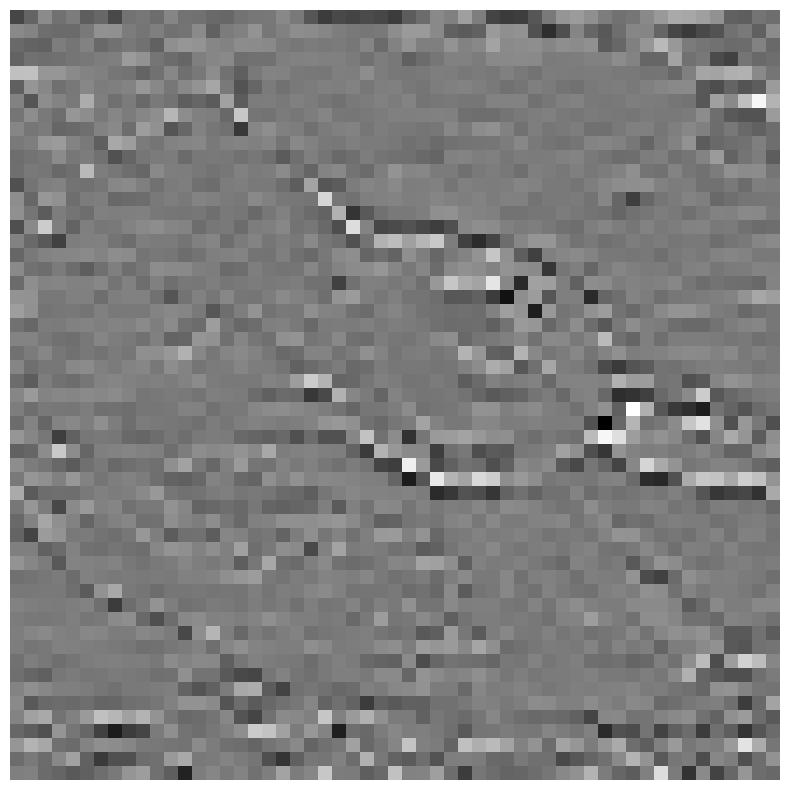

Predicted class: sombrero


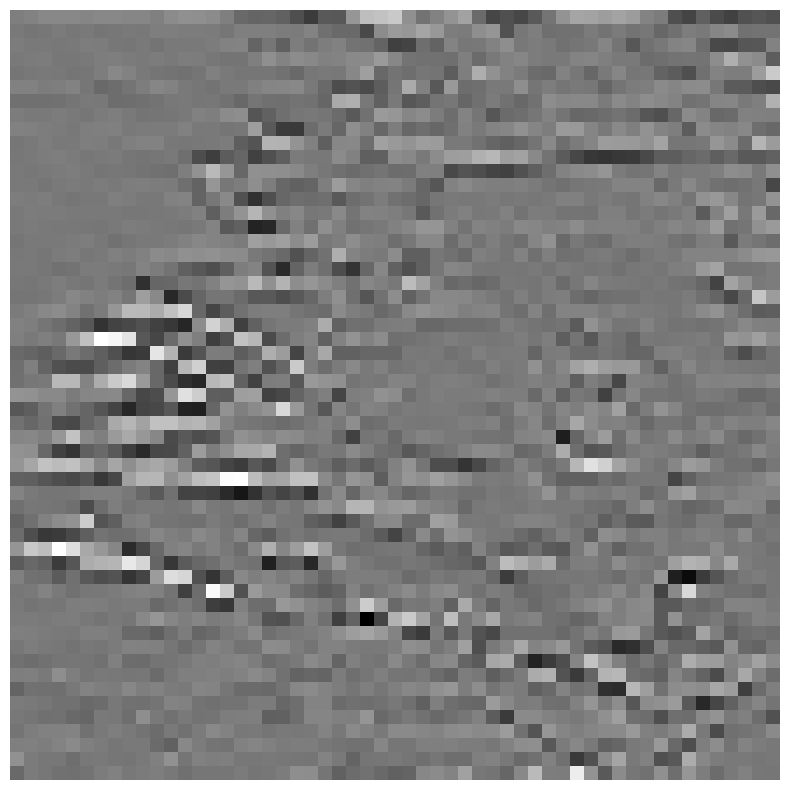

Predicted class: sarong


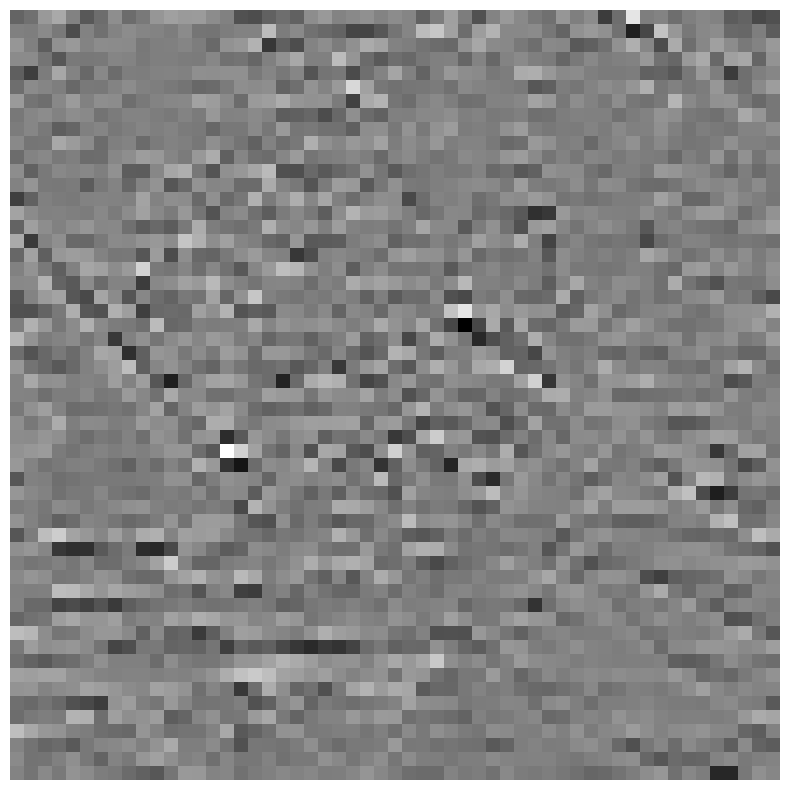

Predicted class: pinwheel


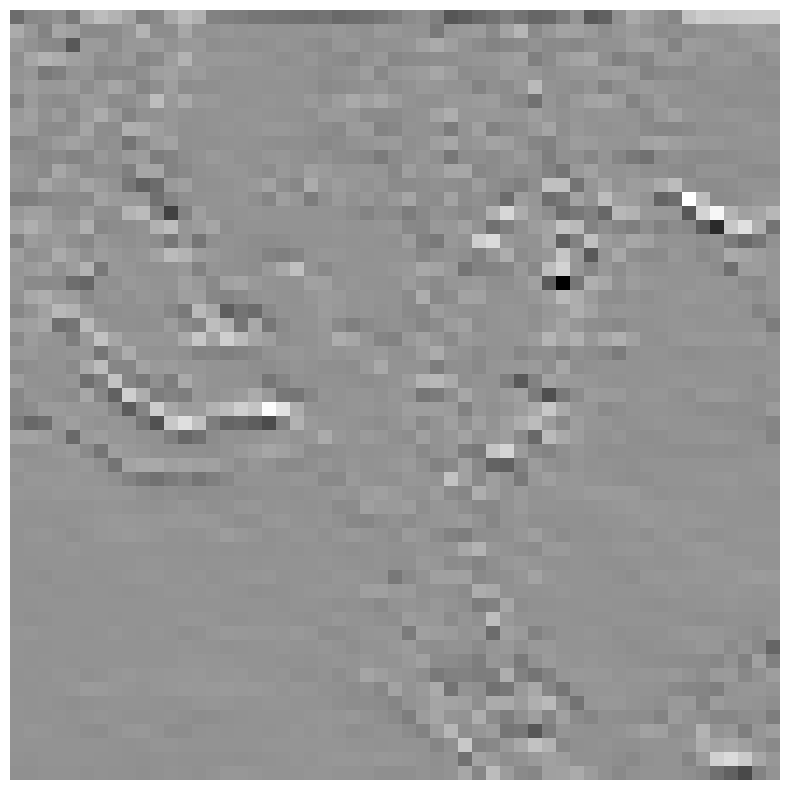

In [17]:
labs = {int(key):value for (key, value) in requests.get('https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json').json().items()}
im, la = next(iter(dataloaders['train']))
for i in range(16):
  img = to_pil(im[i])
  img_t = preprocess(img).unsqueeze_(0).to(device)
  out = net(img_t)
  label_index = out.cpu().data.numpy().argmax()
  print('Predicted class:', labs[label_index.item()])
  out = net.features[0](img_t).cpu().detach().numpy()
  plot2(out[0,10,:,:])

Train the AlexNet model for the specified number of epochs

In [18]:
net = train_model(net, num_epochs=10)

Epoch:  1 / 10
Train  Acc: 0.12
Valid  Acc: 0.26
#######################
Epoch:  2 / 10
Train  Acc: 0.31
Valid  Acc: 0.50
#######################
Epoch:  3 / 10
Train  Acc: 0.45
Valid  Acc: 0.59
#######################
Epoch:  4 / 10
Train  Acc: 0.53
Valid  Acc: 0.70
#######################
Epoch:  5 / 10
Train  Acc: 0.58
Valid  Acc: 0.70
#######################
Epoch:  6 / 10
Train  Acc: 0.60
Valid  Acc: 0.73
#######################
Epoch:  7 / 10
Train  Acc: 0.64
Valid  Acc: 0.75
#######################
Epoch:  8 / 10
Train  Acc: 0.77
Valid  Acc: 0.87
#######################
Epoch:  9 / 10
Train  Acc: 0.81
Valid  Acc: 0.88
#######################
Epoch:  10 / 10
Train  Acc: 0.82
Valid  Acc: 0.89
#######################
